In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.stats.multitest as multi

from CosinorPy import file_parser, cosinor, cosinor1
from CosinorPy.helpers import df_add_row
from RhythmCount import data_processing as dproc
from RhythmCount import plot

In [3]:
data = pd.read_csv("../PrometneNesreče.csv")

C:\Users\Hana\AppData\Local\Temp\ipykernel_23784\3596567331.py:1: DtypeWarning: Columns (31,32,33,34,42,43) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv("../PrometneNesreče.csv")


In [4]:
# Število prometnih nesreč po urah
# Pretvori stolpec 'NastanekDatumCas' v pravilen format (vsaka vrednost bo pandas objekt za datum in čas)
data['NastanekDatumCas'] = pd.to_datetime(data['NastanekDatumCas'], format='ISO8601', errors='coerce')

# Za vsak vnos pridobi znotraj, katere ure se je zgodil
hours = data['NastanekDatumCas'].dt.hour

accidents_per_hour = hours.value_counts()

# Uredi podatke po vrstnem redu ur (naraščajoče)
accidents_per_hour = accidents_per_hour.sort_index()

# Ustvari pandas dataframe v formatu, ki bo primeren za uporabo CosinorPy
df_plot = pd.DataFrame({
    "test": "HourlyAccidents",  # konstantna oznaka vseh vrstic
    "x": accidents_per_hour.index,  # Ura (od 0 do 23)
    "y": accidents_per_hour.values  # Število nesreč za tisto uro
})

#print(df_plot)

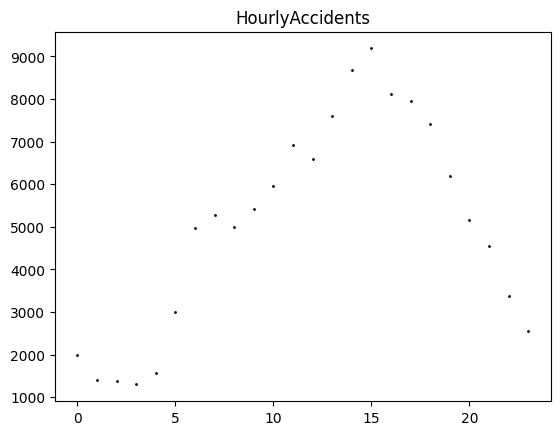

In [5]:
cosinor.plot_data(df_plot, names = ["HourlyAccidents"])

## Periodogram

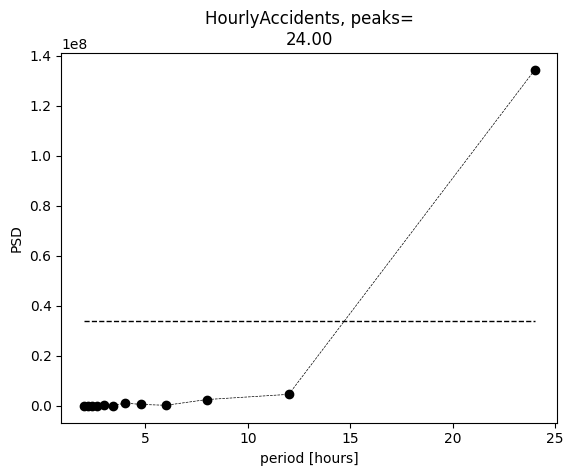

In [6]:
cosinor.periodogram_df(df_plot)

## CosinorPy

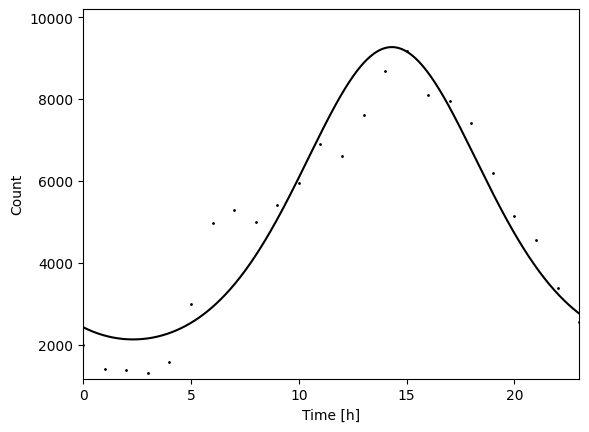

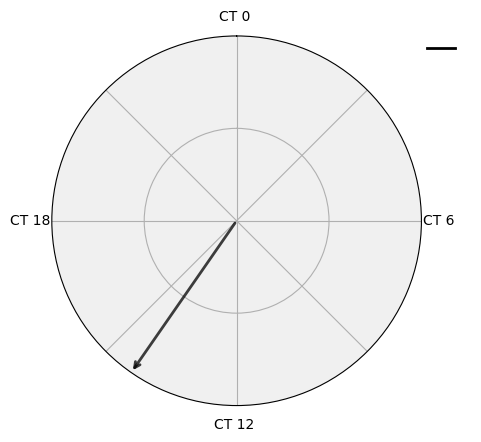

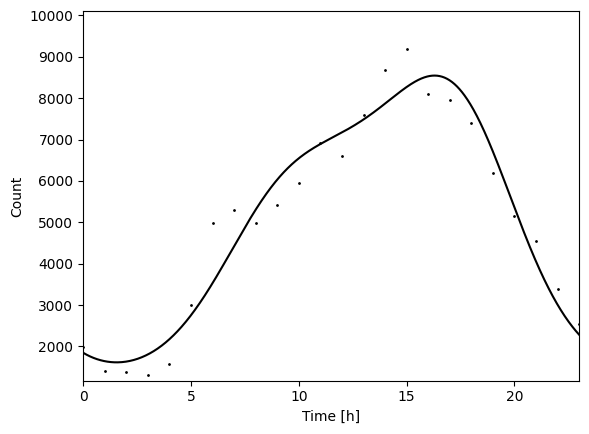

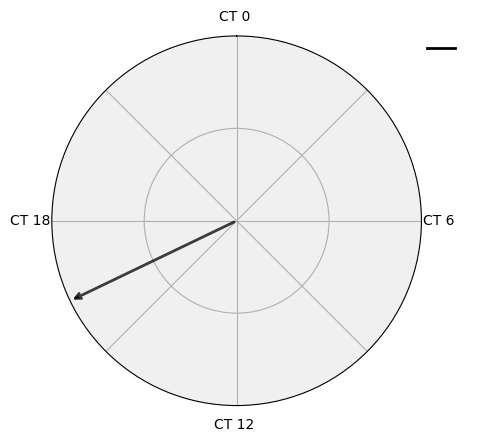

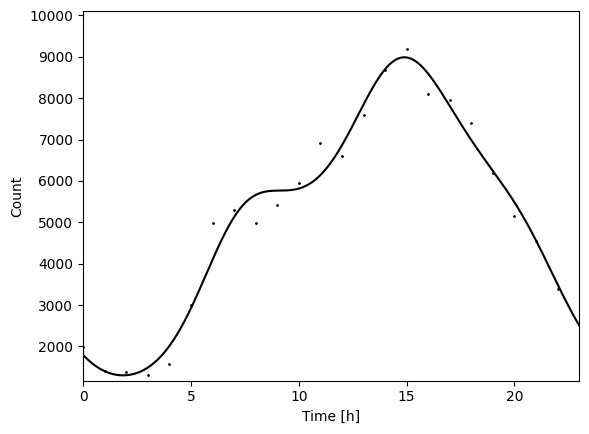

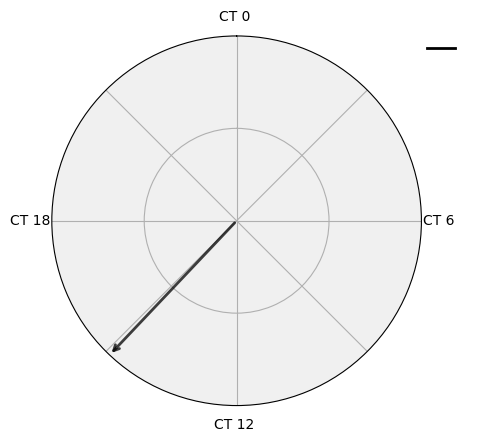

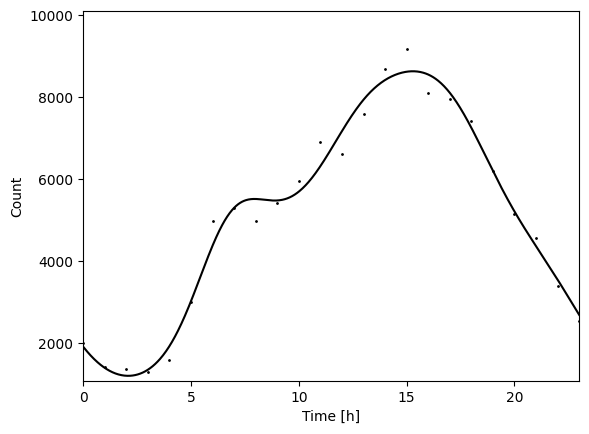

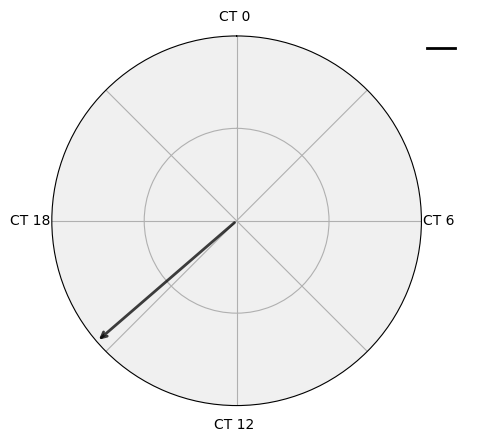

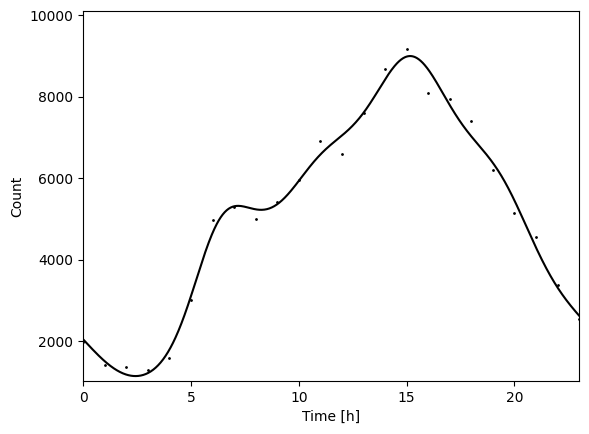

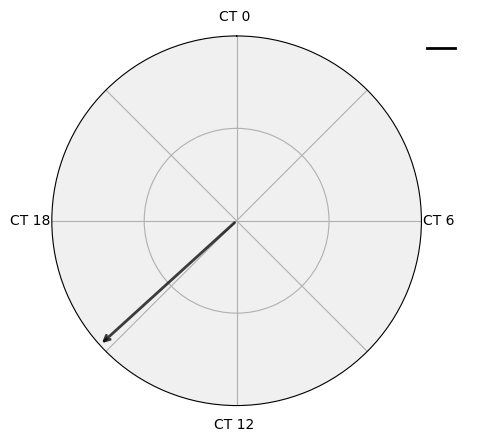

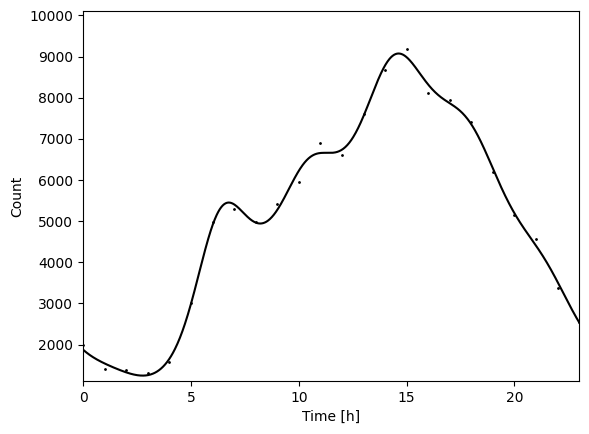

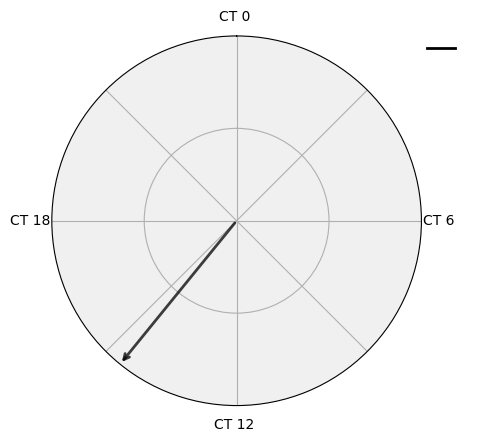

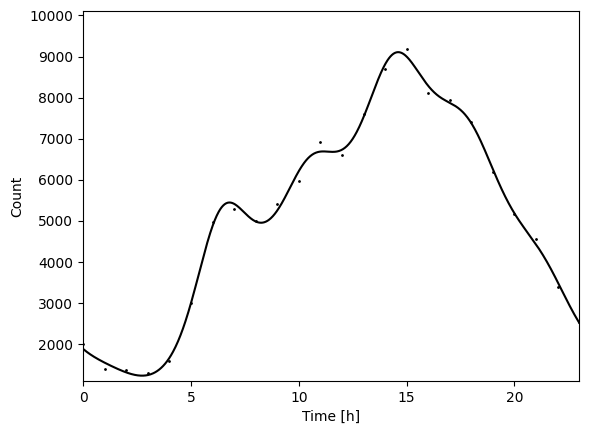

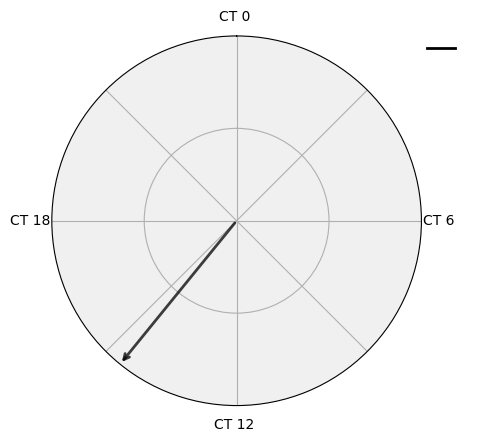

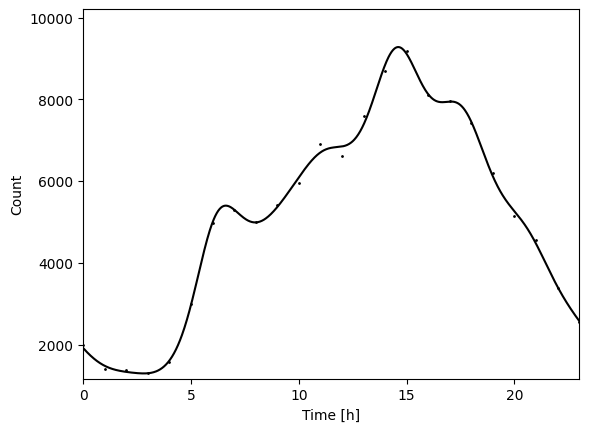

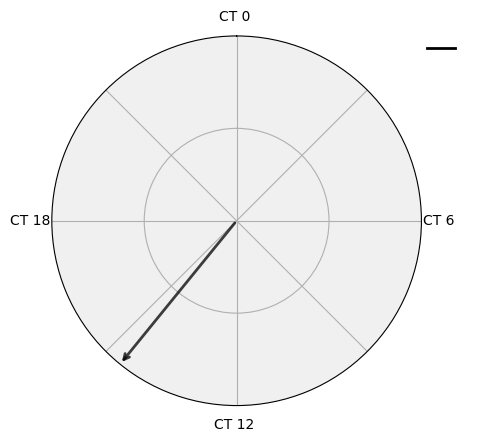

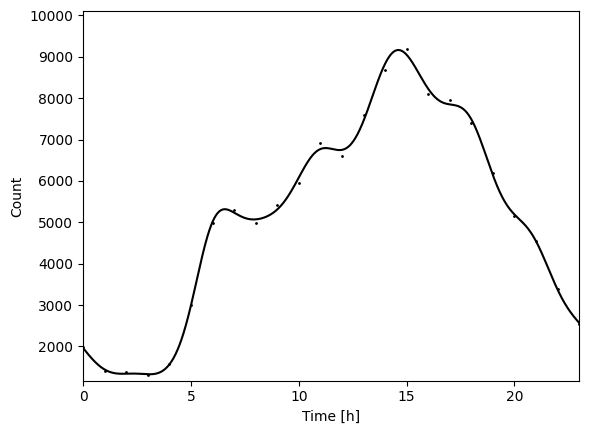

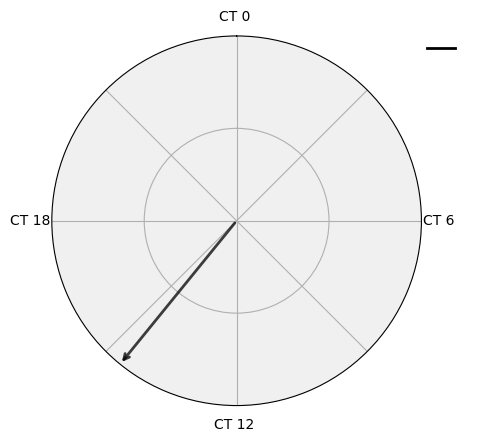

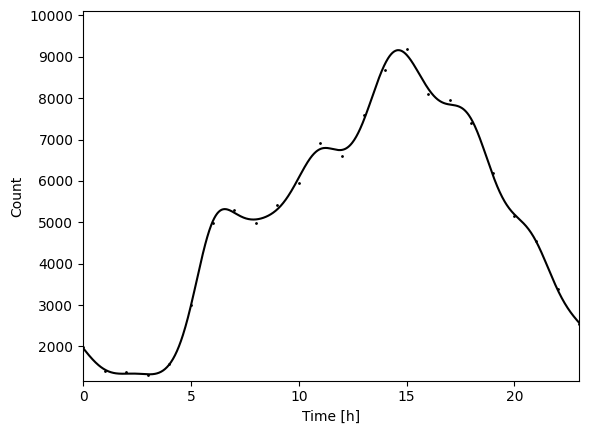

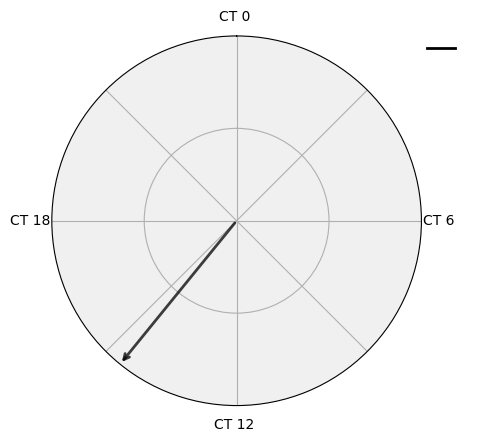

In [32]:
#df_results = cosinor.fit_group(df_plot, n_components = [1,2,3,4,5,6,7,8], period = 24)

X = df_plot.x.to_numpy()
Y = df_plot.y.to_numpy()

df_results = pd.DataFrame(columns=[
    'test', 'period', 'n_components', 'p', 'q', 'RSS', 
    'log-likelihood', 'prsquared', 'amplitude', 'acrophase', 
    'mesor', 'peaks', 'heights', 'troughs', 'heights2'
], dtype=float)


numbers = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
for i in numbers:
    results, statistics, rhythm_param, _, _ = cosinor.fit_me(X, Y, n_components = i, period = 24, model_type = 'gen_poisson', plot_margins=False)
    #result_table.append(result)

    # print("Statistics:", statistics.keys())
    # print("Rhythm parameters:", rhythm_param.keys())
    # print("Results attributes:", dir(results))

    df_results = df_add_row(df_results, {
        'test': 'HourlyAccidents', 
        'period': 24,
        'n_components': i,
        'p': statistics['p'], 
        'RSS': statistics['RSS'],
        'log-likelihood': results.llf,        
        'prsquared': results.prsquared,  # Alternative to R²
        'amplitude': rhythm_param['amplitude'],
        'acrophase': rhythm_param['acrophase'],
        'mesor': rhythm_param['mesor'],
        'peaks': rhythm_param['peaks'],
        'heights': rhythm_param['heights'],
        'troughs': rhythm_param['troughs'],
        'heights2': rhythm_param['heights2']
    })



df_results.q = multi.multipletests(df_results.p, method = 'fdr_bh')[1]

# results = {}
# for n in [1,2,3,4,5,6,7,8]:
#     results[n] = cosinor.fit_me(X, Y, n_components = 1, period = 24, model_type = 'gen_poisson')
#print(df_results)

In [33]:
display(df_results)

,test,period,n_components,p,q,RSS,log-likelihood,prsquared,amplitude,acrophase,mesor,peaks,heights,troughs,heights2
0,HourlyAccidents,24.0,1.0,1.853505e-12,1.853505e-12,1.724763e+07,-196.529123,0.120844,3569.987199,2.534658,5700.516713,[14.318318318318319],[9270.503912848588],[2.3063063063063063],[2130.529514122379]
1,HourlyAccidents,24.0,2.0,1.109044e-15,1.232271e-15,7.673356e+06,-185.441628,0.170443,3465.828646,2.018921,5080.927904,[16.28828828828829],[8546.756549357262],[1.5375375375375375],[1615.1090276406096]
2,HourlyAccidents,24.0,3.0,3.147911e-19,3.934889e-19,3.001240e+06,-173.779072,0.222615,3845.387727,2.383711,5143.125721,[14.894894894894895],[8988.51344804704],[1.8738738738738738],[1297.7931692570412]
3,HourlyAccidents,24.0,4.0,1.227653e-19,1.753790e-19,2.389314e+06,-169.780796,0.240501,3719.306336,2.283079,4916.325197,"[7.927927927927928, 15.27927927927928]","[5516.689251752486, 8635.631532879093]",[2.066066066066066],[1197.1036375664644]
4,HourlyAccidents,24.0,5.0,4.861238e-21,8.102064e-21,1.386942e+06,-163.500173,0.268597,3929.245412,2.308237,5071.972619,"[7.1591591591591595, 15.183183183183184]","[5322.549921771869, 9000.994654584701]",[2.4504504504504503],[1142.8376187408828]
5,HourlyAccidents,24.0,6.0,1.379390e-25,3.448475e-25,3.985264e+05,-149.495112,0.331247,3915.292974,2.459185,5159.141853,"[6.774774774774775, 11.195195195195195, 14.606...","[5450.801575331627, 6659.8023945955165, 9074.1...","[2.7387387387387387, 8.216216216216216]","[1243.9176899679824, 4941.171302971373]"
6,HourlyAccidents,24.0,7.0,1.397668e-24,2.795335e-24,3.683981e+05,-149.265223,0.332275,3936.991329,2.459185,5169.264472,"[6.774774774774775, 11.147147147147146, 14.606...","[5446.821055031268, 6689.926299601561, 9106.25...","[2.7387387387387387, 8.264264264264265]","[1232.2731423334517, 4954.218528974221]"
7,HourlyAccidents,24.0,8.0,1.633483e-26,5.444942e-26,2.491465e+05,-141.776356,0.365776,3992.007295,2.459185,5286.532092,"[6.63063063063063, 14.606606606606606, 17.0570...","[5398.927327144444, 9278.539386626126, 7945.02...","[2.7867867867867866, 7.975975975975976]","[1294.5723483032348, 4988.367687592006]"
8,HourlyAccidents,24.0,9.0,1.366350e-27,1.366350e-26,1.825565e+05,-136.459994,0.389558,3918.865657,2.459185,5245.806240,"[6.5825825825825826, 11.243243243243244, 14.60...","[5316.348156696632, 6794.7404049881225, 9164.6...","[1.8258258258258258, 3.075075075075075, 7.8798...","[1338.7656763375328, 1326.9405829298605, 5069...."
9,HourlyAccidents,24.0,10.0,1.330713e-26,5.444942e-26,1.832266e+05,-136.453294,0.389588,3917.709266,2.459185,5243.624906,"[6.5825825825825826, 11.243243243243244, 14.60...","[5319.106456612785, 6797.643095391215, 9161.33...","[1.8258258258258258, 3.075075075075075, 7.8798...","[1339.670127451832, 1325.915640489897, 5066.98..."


### Katero je najboljše število komponent

In [34]:
df_best_model = cosinor.get_best_models(df_plot, df_results, n_components = [1,2,3,4,5,6,7,8,9,10])
df_best_model

,test,period,n_components,p,q,RSS,log-likelihood,prsquared,amplitude,acrophase,mesor,peaks,heights,troughs,heights2
0,HourlyAccidents,24.0,6.0,1.379390e-25,3.448475e-25,398526.381354,-149.495112,0.331247,3915.292974,2.459185,5159.141853,"[6.774774774774775, 11.195195195195195, 14.606...","[5450.801575331627, 6659.8023945955165, 9074.1...","[2.7387387387387387, 8.216216216216216]","[1243.9176899679824, 4941.171302971373]"


c:\Users\Hana\AppData\Local\Programs\Python\Python312\Lib\site-packages\CosinorPy\cosinor.py:1658: RuntimeWarning: invalid value encountered in scalar divide
  F = (SSLOF/(n_T-1-2*n_components))/(SSPE/(N-n_T))


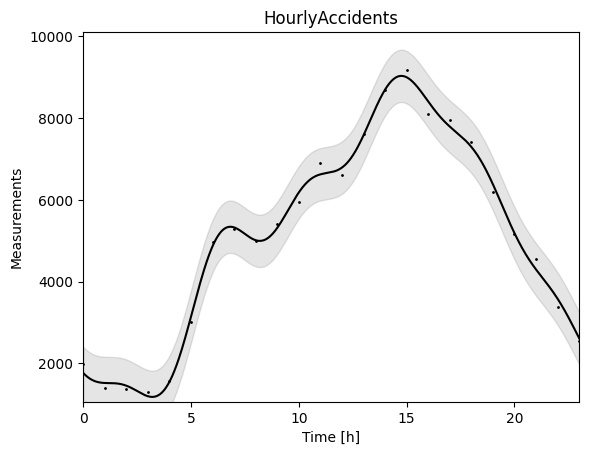

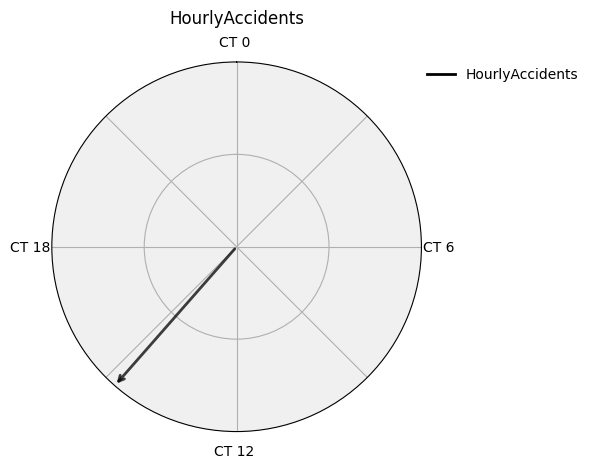

In [35]:
cosinor.plot_df_models(df_plot, df_best_model)

## RhythmCount

In [38]:
# Ustvari pandas dataframe v formatu, ki bo primeren za uporabo RhythmCount
df_plot_RC = pd.DataFrame({
    "test": "HourlyAccidents",  # konstantna oznaka vseh vrstic
    "X": accidents_per_hour.index,  # Ura (od 0 do 23)
    "Y": accidents_per_hour.values  # Število nesreč za tisto uro
})

In [36]:
count_models = ['gen_poisson', 'nb']
n_components = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

c:\Users\Hana\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Hana\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Hana\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Hana\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimizat

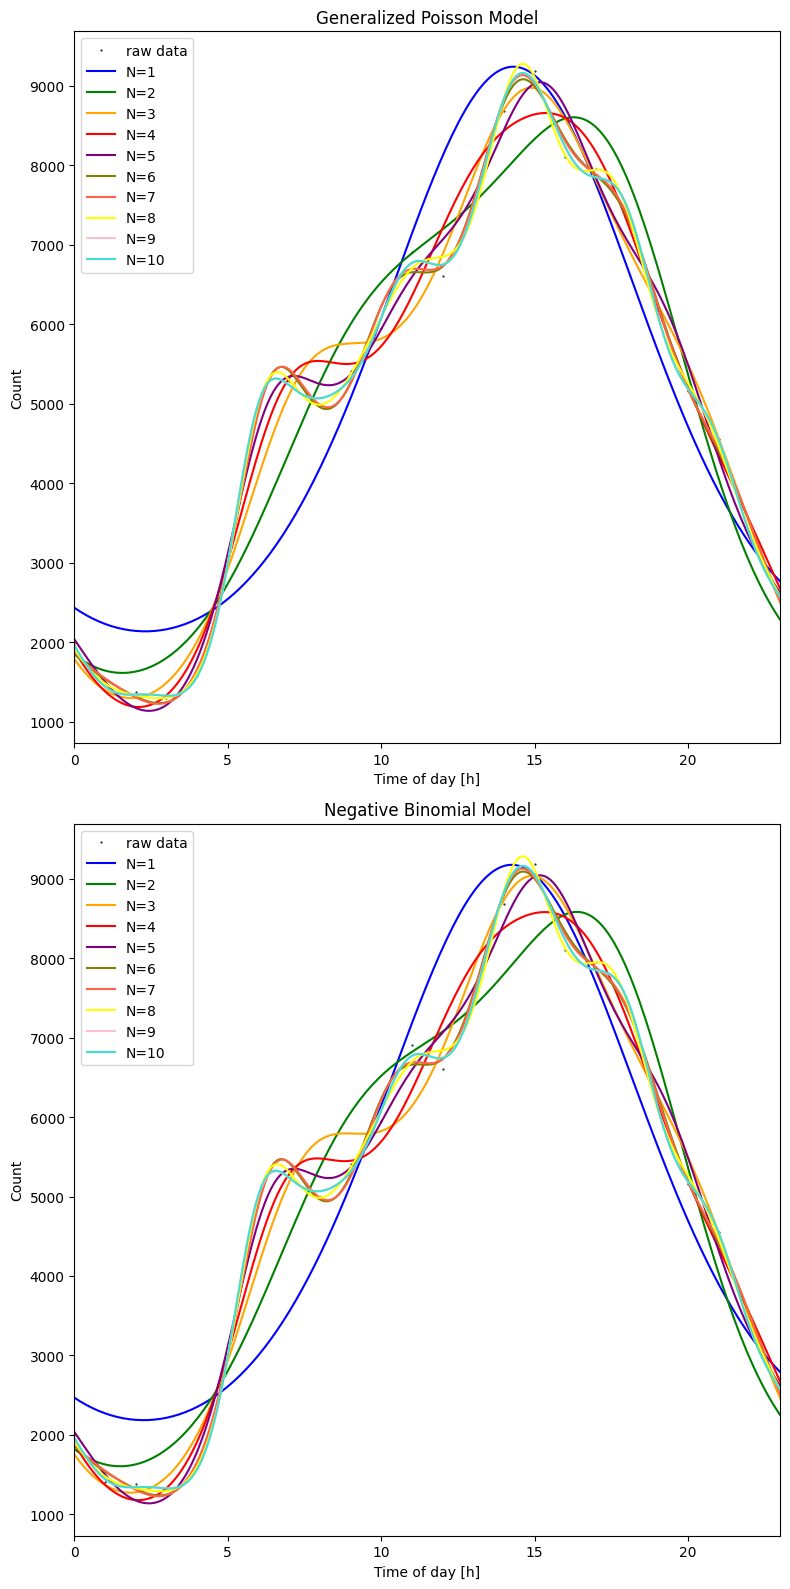

In [39]:
df_results_RC = dproc.fit_to_models(df_plot_RC, count_models, n_components, 24)

In [40]:
display(df_results_RC)

,count_model,n_components,amplitude,mesor,peaks,heights,llr_pvalue,RSS,AIC,BIC,log_likelihood,logs,mean(est),Y(est),X_test,Y_test
0,gen_poisson,1,3552.00,5688.70,[14.31],[9240.7],1.857830e-12,1.710301e+07,401.062906,405.775121,-196.531453,"[-7.408040689781501, -7.999129136464489, -7.85...",5059.263998,"[2432.8455107172185, 2229.6968672441294, 2141....","[0.0, 0.1001001001001001, 0.2002002002002002, ...","[2432.8455107172185, 2406.9552079211276, 2382...."
1,gen_poisson,2,3494.98,5108.89,[16.32],[8603.87],1.134928e-15,7.697551e+06,382.930609,389.998932,-185.465304,"[-7.001964126994835, -6.825963575017795, -6.85...",5072.913246,"[1847.5537713572774, 1642.779667124844, 1630.9...","[0.0, 0.1001001001001001, 0.2002002002002002, ...","[1847.5537713572774, 1817.4388343242597, 1789...."
2,gen_poisson,3,3838.81,5136.72,[14.91],[8975.54],3.167482e-19,2.989775e+06,363.571048,372.995479,-173.785524,"[-6.846525494522666, -6.191152853418998, -6.29...",5066.259440,"[1786.558784112925, 1396.9234161460843, 1300.8...","[0.0, 0.1001001001001001, 0.2002002002002002, ...","[1786.558784112925, 1733.1382474101183, 1683.0..."
3,gen_poisson,4,3736.45,4921.45,[15.32],[8657.9],1.322903e-19,2.421276e+06,359.719702,371.500240,-169.859851,"[-6.360472627938179, -6.063974662439705, -6.80...",5077.805566,"[1898.6093218052579, 1380.4515849782367, 1186....","[0.0, 0.1001001001001001, 0.2002002002002002, ...","[1898.6093218052579, 1832.936953524274, 1770.1..."
4,gen_poisson,5,3954.72,5091.07,[15.22],[9045.79],1.034264e-20,1.409555e+06,352.616853,366.753499,-164.308427,"[-6.126785475450788, -6.086815067459611, -6.98...",5080.887915,"[2034.6940606729524, 1499.529593000463, 1172.5...","[0.0, 0.1001001001001001, 0.2002002002002002, ...","[2034.6940606729524, 1977.4495823871848, 1920...."
5,gen_poisson,6,3924.46,5158.67,[14.61],[9083.13],2.351362e-25,3.987782e+05,328.133323,344.626077,-150.066662,"[-6.3484621607726694, -6.49255881031263, -5.61...",5064.959021,"[1867.7835285402364, 1533.3509862143997, 1314....","[0.0, 0.1001001001001001, 0.2002002002002002, ...","[1867.7835285402364, 1823.0668222706274, 1781...."
6,gen_poisson,7,3955.39,5180.34,[14.61],[9135.73],5.240951e-24,3.698184e+05,333.404949,352.253810,-150.702474,"[-6.166131772753715, -6.564411362875944, -5.74...",5072.395102,"[1880.5789613821505, 1545.4790888790676, 1305....","[0.0, 0.1001001001001001, 0.2002002002002002, ...","[1880.5789613821505, 1837.638747758629, 1797.5..."
7,gen_poisson,8,3992.10,5286.19,"[14.61, 17.02]","[9278.29, 7944.01]",2.239778e-26,2.490560e+05,320.242438,341.447407,-142.121219,"[-5.900937941311895, -6.134120495517664, -5.20...",5065.416667,"[1916.0207744403228, 1481.1957752365245, 1331....","[0.0, 0.1001001001001001, 0.2002002002002002, ...","[1916.0207744403228, 1858.5075056454605, 1803...."
8,gen_poisson,9,3918.94,5245.90,[14.61],[9164.84],3.290411e-27,1.825553e+05,314.854197,338.415274,-137.427099,"[-4.930799351186579, -5.014377922674157, -4.97...",5065.416667,"[1959.0252835712001, 1440.4901280562617, 1340....","[0.0, 0.1001001001001001, 0.2002002002002002, ...","[1959.0252835712001, 1893.974219605388, 1830.0..."
9,gen_poisson,10,3917.74,5243.74,[14.61],[9161.48],3.160926e-26,1.832251e+05,318.834748,344.751932,-137.417374,"[-4.959532270880118, -5.031676364310215, -4.96...",5065.416667,"[1957.62899956063, 1441.0394764957498, 1340.68...","[0.0, 0.1001001001001001, 0.2002002002002002, ...","[1957.62899956063, 1892.4531078478826, 1828.50..."


## Kateri model je najboljši?

#### Najprej pogledamo, kateri model je najboljši, nato kolikšno število komponent je najboljše.

In [41]:
best_count_model = dproc.get_best_count_model(df_results_RC, 'Vuong')
print("Best model: {}".format(best_count_model.count_model))
best_model = dproc.get_best_n_components(df_results_RC, 'Vuong', count_model=best_count_model['count_model'])
print("Number of components: {}".format(best_model.n_components))

Best model: gen_poisson
Number of components: 6


#### Najprej pogledamo, kolikšno število komponent je najboljše, nato, kateri model je najboljši. 

In [42]:
best_n_components = dproc.get_best_n_components(df_results_RC, 'Vuong')
print("Number of components: {}".format(best_n_components.n_components))
best_model = dproc.get_best_count_model(df_results_RC, 'Vuong', n_components=best_n_components['n_components'])
print("Best model: {}".format(best_model.count_model))

Number of components: 6
Best model: gen_poisson


### Prikaz najboljšega modela skupaj z intervali zaupanja

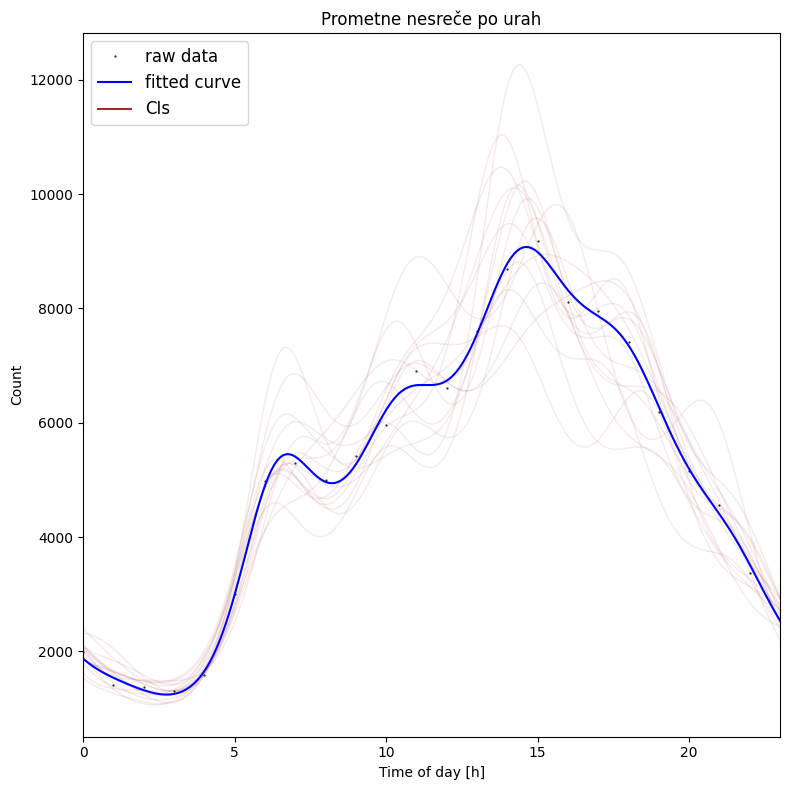

Intervali zaupanja:


,0,1
0,8.298960,8.434920
1,-0.512429,-0.326562
2,-0.765731,-0.640838
3,-0.255972,-0.131186
4,-0.265587,-0.125601
5,-0.217414,-0.104406
6,-0.003814,0.091398
7,-0.032680,0.047698
8,-0.005202,0.129655
9,0.016018,0.135710


In [43]:
# print(type(best_model))
# print(type(best_n_components))

# print(best_n_components)

count_model = best_model.count_model
n_components = int(best_n_components.n_components)

CIs = plot.plot_model(df_plot_RC, count_model, n_components, title='Prometne nesreče po urah', plot_CIs=True)
print('Intervali zaupanja:')
display(CIs)

### Parametri izbranega modela

In [44]:
CIs_params = dproc.calculate_confidence_intervals_parameters(df_plot_RC, n_components, count_model, best_model['peaks'])
best_model = pd.concat([best_model, pd.Series(CIs_params)], axis=0)
best_model=best_model[['count_model','n_components','amplitude', 'mesor', 'peaks', 'heights','amplitude_CIs','mesor_CIs','peaks_CIs','heights_CIs']]
print('Parametri modela in njihovi intervali zaupanja:')
display(best_model.to_frame())

c:\Users\Hana\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Parametri modela in njihovi intervali zaupanja:


,0
count_model,gen_poisson
n_components,6
amplitude,3924.46
mesor,5158.67
peaks,[14.61]
heights,[9083.13]
amplitude_CIs,"[2579.28, 5524.77]"
mesor_CIs,"[3786.46, 6765.24]"
peaks_CIs,"[13.77, 15.39]"
heights_CIs,"[6342.96, 12287.6]"
